In [349]:
import pickle
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import numpy as np
from math import ceil,floor

### LETTURA DATI - Dataset

In [350]:
with open('instances_dataset.pickle', 'rb') as f:
    INSTANCES = pickle.load(f)

def map_density(d):
    if (d % 1) <= 0.5:
        return floor(d) + 0.5
    else:
        return ceil(d)

count_instances = 0
DATA = []
for idx,instance in enumerate(INSTANCES):

    nw_size = int(instance[0].removeprefix('DATASET_2/networks/network_0')[:2])
    if nw_size > 70:
        continue
    count_instances += 1
    d = {'ID':idx}
    d['nw_size'] = nw_size
    d['#apps'] = len(instance[4])
    d['#msvcs'] = 0
    for el in instance[4]:
        if el.startswith('DATASET_2/apps/graph_'): d['#msvcs'] += int(el.removeprefix('DATASET_2/apps/graph_')[:2])
        elif el.startswith('DATASET_2/apps/tree_'): d['#msvcs'] += int(el.removeprefix('DATASET_2/apps/tree_')[:2])
        elif el.startswith('DATASET_2/apps/path_'): d['#msvcs'] += int(el.removeprefix('DATASET_2/apps/path_')[:2])
        else: raise AssertionError('unreachable')
    d['density'] = map_density(d['#msvcs'] / d['nw_size'])
    DATA.append(d)


### LETTURA DATI - Root Node Relaxation

In [351]:
with open('log_files/RNR.txt', 'r') as f:
    rnr_results = f.read().split("\n\n")
assert len(rnr_results) == count_instances
print("#rnr results : ", len(rnr_results))

#rnr results :  435


In [352]:
for idx,v in enumerate(rnr_results):

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert id == idx and apps_count == DATA[id]['#apps']

    rnr_data = v[1].removeprefix("RNR ")
    if rnr_data == "Unabletocreatepresolvedmodel":
        DATA[id]['rnr_status'] = 'INFEASIBLE_EX'
    else:
        rnr_data = eval(rnr_data)
        assert len(rnr_data) == 3
        DATA[id]['rnr_time'] = round(rnr_data[0],3)
        DATA[id]['rnr_status'] = rnr_data[1]
        if rnr_data[2] is not None:
            DATA[id]['rnr_z'] = rnr_data[2]


### LETTURA DATI - Compact Model 

calcolato solo per le istanze in cui RNR non è infeasible

In [353]:
with open('log_files/COMPACT.txt', 'r') as f:
    compact_results = f.read().split("\n\n")

print("#compact results : ", len(compact_results))

#compact results :  201


In [354]:
for v in compact_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    compact_data = eval(v[1].removeprefix("COMPACT "))
    assert len(compact_data) == 5
    
    DATA[id]['compact_time'] = round(compact_data[0],3)
    DATA[id]['compact_status'] = compact_data[1]
    assert compact_data[2] % 1 == 0
    DATA[id]['compact_#nodes'] = int(compact_data[2])
    
    if compact_data[1] == 'INFEASIBLE':
        assert compact_data[3] is None and compact_data[4] is None
    elif compact_data[1] == 'OPTIMAL':
        assert compact_data[3] is not None and compact_data[4] is None
        DATA[id]['compact_z*'] = float(compact_data[3])
    elif compact_data[1] == 'TIME_LIMIT_>30min':
        assert compact_data[3] is not None and compact_data[4] is not None
        DATA[id]['compact_status'] += ("_primal" if compact_data[3] != "inf" else "_inf")
        DATA[id]['compact_z*'] = float(compact_data[3]) if compact_data[3] != "inf" else "inf"
        DATA[id]['compact_z_lb'] = float(compact_data[4])
    else:
        raise AssertionError('unreachable')

### LETTURA DATI - CG basic

calcolato solo per le istanze in cui RNR non è infeasible

In [355]:
with open('log_files/CG.txt', 'r') as f:
    cg_results = f.read().split("\n\n")

print("#cg results : ", len(cg_results))

#cg results :  201


In [356]:
#   GAP             #iterations     LR_dual_bound   CG_time     -
#   GAP             #iterations     LR_dual_bound   CG_time     CG_dà_ottimo_intero
#   INF_dummy       #iterations     -               CG_time     -
#   INF_pricing

In [357]:
for v in cg_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    cg_data = v[1].split()

    if cg_data[0] == 'GAP':
        assert len(cg_data) == 4 or len(cg_data) == 5
        DATA[id]['CG_status'] = cg_data[0]
        DATA[id]['CG_#iter'] = int(cg_data[1])
        DATA[id]['CG_LR_bound'] = float(cg_data[2])
        DATA[id]['CG_time'] = round(float(cg_data[3]),3)
        if len(cg_data) == 5:
            DATA[id]['CG_int_sol'] = int(float(cg_data[4]))

    elif cg_data[0] == 'INF_dummy':
        assert len(cg_data)==3
        DATA[id]['CG_status'] = "INF"#cg_data[0]
        DATA[id]['CG_#iter'] = int(cg_data[1])
        DATA[id]['CG_time'] = round(float(cg_data[2]),3)
        
    elif cg_data[0] == 'INF_pricing':
        assert len(cg_data)==1
        DATA[id]['CG_status'] = "INF"#cg_data[0]
        
    else:
        raise AssertionError('unreachable')

### LETTURA DATI - CG with heuristic pricing

In [358]:
with open('log_files/CG_HP.txt', 'r') as f:
    cg_results = f.read().split("\n\n")

print("#cg heuristic results : ", len(cg_results))

#cg heuristic results :  201


In [359]:
for v in cg_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    cg_data = v[1].split()

    if cg_data[0] == 'GAP':
        assert len(cg_data) == 4 or len(cg_data) == 5
        DATA[id]['CGh_status'] = cg_data[0]
        DATA[id]['CGh_#iter'] = int(cg_data[1])
        DATA[id]['CGh_LR_bound'] = float(cg_data[2])
        DATA[id]['CGh_time'] = round(float(cg_data[3]),3)
        if len(cg_data) == 5:
            DATA[id]['CGh_int_sol'] = int(float(cg_data[4]))

    elif cg_data[0] == 'INF_dummy':
        assert len(cg_data)==3
        DATA[id]['CGh_status'] = "INF"#cg_data[0]
        DATA[id]['CGh_#iter'] = int(cg_data[1])
        DATA[id]['CGh_time'] = round(float(cg_data[2]),3)
        
    elif cg_data[0] == 'INF_pricing':
        assert len(cg_data)==1
        DATA[id]['CGh_status'] = "INF"#cg_data[0]
        
    else:
        raise AssertionError('unreachable')

### LETTURA DATI - CG basic + discrete LRMP

In [360]:
with open('log_files/DLRMP.txt', 'r') as f:
    drmp_pd_results = f.read().split("\n\n")

print("#drmp_pd_results results : ", len(drmp_pd_results))

#drmp_pd_results results :  201


In [361]:
for v in drmp_pd_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    drmp_pd_data = v[1].split()

    if drmp_pd_data[0] == 'GAP' and len(drmp_pd_data) == 4:
        assert len(v) == 3

        # discrete LRMP
        drmp = v[2].split()
        if drmp[0] == "discrete_RMP_fail":
            DATA[id]['DRMP_status'] = ""
            DATA[id]['DRMP_time'] = round(float(drmp[1]),3)
        else:
            assert drmp[0] == "discrete_RMP_success"
            DATA[id]['DRMP_status'] = "success"
            DATA[id]['DRMP_primal'] = float(drmp[1])
            DATA[id]['DRMP_time'] = round(float(drmp[2]),3)

    else:
        assert len(v) == 2
        assert (drmp_pd_data[0] == 'GAP' and len(drmp_pd_data) == 5) or drmp_pd_data[0] == 'INF_dummy' or drmp_pd_data[0] == 'INF_pricing'
        

### LETTURA DATI - CG basic + Pure Diving

In [362]:
with open('log_files/PD.txt', 'r') as f:
    pd_results = f.read().split("\n\n")

print("#pd_results results : ", len(pd_results))

#pd_results results :  201


In [363]:
for v in pd_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    drmp_pd_data = v[1].split()

    if drmp_pd_data[0] == 'GAP' and len(drmp_pd_data) == 4:
        assert len(v) == 3

        # pure diving
        pure_diving = v[2].split()
        assert len(pure_diving) == 3
        if pure_diving[0] == "PureDiving_fail":
            assert pure_diving[1] == "INF_dummy" or pure_diving[1] == "INF_pricing"
            DATA[id]['PD_status'] = ""
            DATA[id]['PD_time'] = round(float(pure_diving[2]),3)
        else:
            assert pure_diving[0] == "PureDiving_success"
            DATA[id]['PD_status'] = "success"
            DATA[id]['PD_primal'] = float(pure_diving[1])
            DATA[id]['PD_time'] = round(float(pure_diving[2]),3)

    else:
        assert len(v) == 2
        assert (drmp_pd_data[0] == 'GAP' and len(drmp_pd_data) == 5) or drmp_pd_data[0] == 'INF_dummy' or drmp_pd_data[0] == 'INF_pricing'

### LETTURA DATI - CG basic + Rounding+SubMIPing

In [364]:
with open('log_files/R+S.txt', 'r') as f:
    hr_results = f.read().split("\n\n")

print("#hr_results results : ", len(hr_results))

#hr_results results :  187


In [365]:
for v in hr_results:

    # output sanity check 
    v = v.split("\n")
    id, apps_count = map(int,v[0].split()[:2])
    assert apps_count == DATA[id]['#apps']
    
    hr_data = v[1].split()
    #print(hr_data)

    if hr_data[0] == 'GAP_STOP' and len(hr_data) == 4:
        
        assert len(v) == 3
        #print(v[2])
        time, hr = v[2].removeprefix("rounding_subMIPing ").split()
        
        DATA[id]['hr_time'] = round(float(time),3)

        if hr == "INF_dummy":
            DATA[id]['hr_status'] = ""
            continue

        hr = eval(hr)
        assert len(hr) == 5
        
        assert hr[2] % 1 == 0
        
        if hr[1] == 'INFEASIBLE':
            assert hr[3] is None and hr[4] is None
            DATA[id]['hr_status'] = ""
            DATA[id]['hr_solver_status'] = hr[1]

        elif hr[1] == 'OPTIMAL':
            assert hr[3] is not None and hr[4] is None
            DATA[id]['hr_status'] = "success"
            DATA[id]['hr_solver_status'] = hr[1]
            DATA[id]['hr_primal'] = float(hr[3])

        elif hr[1] == 'TIME_LIMIT_>10min':
            assert hr[3] is not None and hr[4] is not None
            if hr[3] == "inf":
                DATA[id]['hr_status'] = ""
                DATA[id]['hr_solver_status'] = hr[1]
                DATA[id]['hr_primal'] = hr[3]
            else:
                DATA[id]['hr_status'] = "success"
                DATA[id]['hr_solver_status'] = hr[1]
                DATA[id]['hr_primal'] = float(hr[3])
        else:
            raise AssertionError('unreachable')

    else:
        raise AssertionError('unreachable')

### creazione dataframe

In [366]:
df = pd.DataFrame(DATA)
df = df.loc[(df['nw_size'] <= 70)]

### ANALISI - Root Node Relaxation

In [367]:
df

,ID,nw_size,#apps,#msvcs,density,rnr_time,rnr_status,rnr_z,compact_time,compact_status,compact_#nodes,compact_z*,CG_status,CG_#iter,CG_LR_bound,CG_time,CGh_status,CGh_#iter,CGh_LR_bound,CGh_time,DRMP_status,DRMP_primal,DRMP_time,PD_status,PD_primal,PD_time,hr_time,hr_status,hr_solver_status,hr_primal,compact_z_lb,CG_int_sol,CGh_int_sol
0,0,30,2,10,0.5,0.005,OPTIMAL,401.340551,0.067,OPTIMAL,1.0,424.0,GAP,3.0,410.275983,0.242,GAP,3.0,410.275983,0.297,success,424.0,0.001,success,429.0,0.014,0.118,success,OPTIMAL,429.0,NaN,NaN,NaN
1,1,30,2,14,0.5,0.004,OPTIMAL,550.963783,0.024,OPTIMAL,1.0,573.0,GAP,6.0,570.215978,0.196,GAP,5.0,570.215978,0.153,success,573.0,0.001,success,573.0,0.003,0.053,success,OPTIMAL,573.0,NaN,NaN,NaN
2,2,30,2,23,1.0,0.010,OPTIMAL,939.016975,0.209,OPTIMAL,20.0,960.0,GAP,8.0,940.625474,0.619,GAP,9.0,940.654714,0.627,success,964.0,0.001,success,990.0,0.044,0.250,success,OPTIMAL,966.0,NaN,NaN,NaN
3,3,30,3,18,1.0,0.011,OPTIMAL,679.026118,0.074,OPTIMAL,1.0,707.0,GAP,6.0,695.244704,0.625,GAP,5.0,695.463958,0.447,success,746.0,0.002,success,710.0,0.155,0.197,success,OPTIMAL,707.0,NaN,NaN,NaN
4,4,30,3,20,1.0,0.010,OPTIMAL,803.943900,0.041,OPTIMAL,1.0,808.0,GAP,3.0,804.392433,0.256,GAP,4.0,804.392433,0.357,success,808.0,0.001,success,808.0,0.021,0.131,success,OPTIMAL,808.0,NaN,NaN,NaN
5,5,30,3,27,1.0,0.019,OPTIMAL,926.052616,0.288,OPTIMAL,1.0,982.0,GAP,8.0,957.993673,1.658,GAP,8.0,957.993673,1.805,success,1008.0,0.002,success,998.0,0.193,0.384,success,OPTIMAL,982.0,NaN,NaN,NaN
6,6,30,4,36,1.5,0.026,OPTIMAL,1352.906240,0.878,OPTIMAL,48.0,1414.0,GAP,12.0,1373.412700,3.005,GAP,15.0,1373.258138,3.803,,NaN,0.008,success,1436.0,0.413,1.297,success,OPTIMAL,1420.0,NaN,NaN,NaN
7,7,30,4,29,1.0,0.018,OPTIMAL,1074.593219,0.124,OPTIMAL,1.0,1104.0,GAP,8.0,1084.592681,0.882,GAP,11.0,1084.592681,1.308,success,1116.0,0.001,success,1116.0,0.151,0.260,success,OPTIMAL,1104.0,NaN,NaN,NaN
8,8,30,4,40,1.5,0.034,OPTIMAL,1634.089419,0.765,OPTIMAL,154.0,1673.0,GAP,14.0,1645.137138,4.229,GAP,15.0,1645.962633,4.389,,NaN,0.012,success,1704.0,0.516,2.442,success,OPTIMAL,1694.0,NaN,NaN,NaN
9,9,30,5,46,2.0,0.036,OPTIMAL,1941.165665,0.899,OPTIMAL,189.0,2010.0,GAP,19.0,1960.473040,4.544,GAP,19.0,1960.239723,4.695,,NaN,0.020,success,2067.0,0.984,1.605,success,OPTIMAL,2014.0,NaN,NaN,NaN


In [368]:
network_sizes = sorted(list(df['nw_size'].unique()))

df_rnr_by_network = df.groupby('nw_size').agg({
    'rnr_time': ['min', 'max', 'mean', 'std']
})
df_rnr_by_network['#rnr_feasible'] = df.groupby(['nw_size']).apply(lambda group: (group['rnr_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_rnr_by_network['#rnr_infeasible'] = df.groupby(['nw_size']).apply(lambda group: (group['rnr_status'] != "OPTIMAL").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_rnr_by_network['rnr_%_feasible'] = df_rnr_by_network['#rnr_feasible'] / (df_rnr_by_network['#rnr_feasible'] + df_rnr_by_network['#rnr_infeasible'])

#display(df_rnr_by_network)

In [369]:
app_count = sorted(list(df['#apps'].unique()))

df_rnr_by_app = df.groupby('#apps').agg({
    '#apps': ['count'],
    'rnr_time': ['min', 'max', 'mean', 'std']
})
df_rnr_by_app['#rnr_feasible'] = df.groupby(['#apps']).apply(lambda group: (group['rnr_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_rnr_by_app['#rnr_infeasible'] = df.groupby(['#apps']).apply(lambda group: (group['rnr_status'] != "OPTIMAL").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_rnr_by_app['rnr_%_feasible'] = df_rnr_by_app['#rnr_feasible'] / (df_rnr_by_app['#rnr_feasible'] + df_rnr_by_app['#rnr_infeasible'])

#display(df_rnr_by_app)

In [370]:
df_rnr_by_density = df.groupby('density').agg({
    'density': ['count'],
    'rnr_time': ['min', 'max', 'mean', 'std']
})
df_rnr_by_density['#rnr_feasible'] = df.groupby(['density']).apply(lambda group: (group['rnr_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_rnr_by_density['#rnr_infeasible'] = df.groupby(['density']).apply(lambda group: (group['rnr_status'] != "OPTIMAL").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_rnr_by_density['rnr_%_feasible'] = df_rnr_by_density['#rnr_feasible'] / (df_rnr_by_density['#rnr_feasible'] + df_rnr_by_density['#rnr_infeasible'])

display(df_rnr_by_density)

densitities = sorted(list(df['density'].unique()))

density rnr_time                            #rnr_feasible  \
          count      min    max      mean       std                 
density                                                             
0.5          23    0.004  0.245  0.086870  0.072269            23   
1.0          38    0.010  0.669  0.237184  0.184354            38   
1.5          38    0.026  1.004  0.404789  0.272927            38   
2.0          45    0.033  1.695  0.609711  0.467082            45   
2.5          44    0.065  4.151  1.107159  1.001063            40   
3.0          33    0.093  4.044  1.481848  1.157951            16   
3.5          45    0.068  4.270  1.354795  0.907511             1   
4.0          39    0.109  6.347  1.728132  1.369943             0   
4.5          36    0.113  4.308  1.348657  1.211371             0   
5.0          17    0.181  3.704  1.487786  1.115192             0   
5.5          18    0.156  2.539  0.898250  0.611659             0   
6.0          10    0.219  2.450  1.137778  0.707687             0   
6.5          13    0.261  2.652  0.925818  0.867706             0   
7.0           9    0.248  1.604  0.688556  0.435293             0   
7.5           8    0.291  1.524  0.521500  0.409035             0   
8.0           7    0.352  0.655  0.438857  0.105488             0   
8.5           5    0.372  0.712  0.522000  0.173494             0   
9.0           5    0.374  0.869  0.539667  0.285213             0   
9.5           1    0.281  0.281  0.281000       NaN             0   
10.0          1    0.862  0.862  0.862000       NaN             0   

        #rnr_infeasible rnr_%_feasible  
                                        
density                                 
0.5                   0       1.000000  
1.0                   0       1.000000  
1.5                   0       1.000000  
2.0                   0       1.000000  
2.5                   4       0.909091  
3.0                  17       0.484848  
3.5                  44       0.022222  
4.0                  39       0.000000  
4.5                  36       0.000000  
5.0                  17       0.000000  
5.5                  18       0.000000  
6.0                  10       0.000000  
6.5                  13       0.000000  
7.0                   9       0.000000  
7.5                   8       0.000000  
8.0                   7       0.000000  
8.5                   5       0.000000  
9.0                   5       0.000000  
9.5                   1       0.000000  
10.0                  1       0.000000

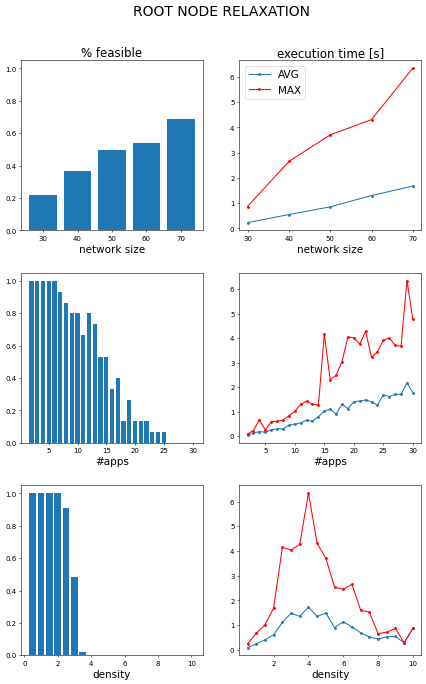

In [284]:
figure, axis = plt.subplots(3, 2)
figure.set_dpi(50)
figure.set_size_inches((10,14))

figure.suptitle('ROOT NODE RELAXATION', fontsize=20)

axis[0,0].bar(network_sizes, df_rnr_by_network['rnr_%_feasible'].to_list(), width=8.0)
axis[0,0].set_title("% feasible", fontsize=17)
axis[0,0].set_ylim((0,1.05))
axis[0,0].set_xlabel("network size", fontsize=15)
axis[0,0].set_xticks(network_sizes)

axis[0,1].plot(network_sizes, df_rnr_by_network[("rnr_time", "mean")].to_list(), label = "AVG", marker='.')
axis[0,1].plot(network_sizes, df_rnr_by_network[("rnr_time", "max")].to_list(), label = "MAX", color='red', marker='.')
axis[0,1].legend(fontsize=15)
axis[0,1].set_title("execution time [s]", fontsize=17)
axis[0,1].set_xlabel("network size", fontsize=15)
axis[0,1].set_xticks(network_sizes)

axis[1,0].bar(app_count, df_rnr_by_app['rnr_%_feasible'].to_list(), width=0.75)
axis[1,0].set_ylim((0,1.05))
axis[1,0].set_xlabel("#apps", fontsize=15)

axis[1,1].plot(app_count, df_rnr_by_app[("rnr_time", "mean")].to_list(), label = "AVG", marker='.')
axis[1,1].plot(app_count, df_rnr_by_app[("rnr_time", "max")].to_list(), label = "MAX", color='red', marker='.')
axis[1,1].set_xlabel("#apps", fontsize=15)

axis[2,0].bar(densitities, df_rnr_by_density['rnr_%_feasible'].to_list(), width=0.4)
axis[2,0].set_ylim((0,1.05))
axis[2,0].set_xlabel("density", fontsize=15)

axis[2,1].plot(densitities, df_rnr_by_density[("rnr_time", "mean")].to_list(), label = "AVG", marker='.')
axis[2,1].plot(densitities, df_rnr_by_density[("rnr_time", "max")].to_list(), label = "MAX", color='red', marker='.')
axis[2,1].set_xlabel("density", fontsize=15)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=None, hspace=0.25)
plt.savefig('output_images/rnr.png', dpi=500)
plt.show()

In [285]:
# we remove the rnr infeasible instances, we will not consider them anymore
print("len before : ", len(df))
df = df[df['rnr_status'] == "OPTIMAL"]
print("len after : ", len(df))

len before :  435
len after :  201


In [286]:
rnr_feasible_instances_indexes = dict()
for size in network_sizes:
    rnr_feasible_instances_indexes[size] = df.loc[(df['nw_size'] == size)]['ID'].tolist()
for k,v in rnr_feasible_instances_indexes.items():
    print(k,v)
    
# with open('rnr_feasible_instances_indexes.pickle', 'wb') as f:
#     pickle.dump(rnr_feasible_instances_indexes, f, protocol=pickle.HIGHEST_PROTOCOL)

30 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
40 [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 117, 118, 119, 120, 122]
50 [174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 215, 216, 221, 223]
60 [261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 307, 308, 312, 322]
70 [348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 399, 400, 401, 402, 403, 406, 407, 408, 412, 416, 417]


In [287]:
df.drop(columns=["rnr_status", "rnr_time"], axis=1, inplace=True) # del RNR lasciamo solo rnr_z, il resto in futuro non ci servirà

/var/folders/pg/zj5j0p614fq_84l8hsgr_40h0000gn/T/ipykernel_2690/3378341801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["rnr_status", "rnr_time"], axis=1, inplace=True) # del RNR lasciamo solo rnr_z, il resto in futuro non ci servirà


### ANALISI - Compact Model

In [288]:
app_count = sorted(list(df['#apps'].unique()))

In [289]:
columns_to_consider = ["ID", "nw_size", "#apps", "#msvcs", "density", "compact_time", "compact_status", "compact_#nodes", "compact_z*"]
df_CM = df[columns_to_consider]

densitities = sorted(list(df_CM['density'].unique()))

#display(df_CM)

In [290]:
df_CM_by_network = df_CM.groupby(('nw_size')).agg({'nw_size': ['count']})

df_CM_by_network['#cm_optimal'] = df_CM.groupby(['nw_size']).apply(lambda group: (group['compact_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_CM_by_network['#cm_infeasible'] = df_CM.groupby(['nw_size']).apply(lambda group: (group['compact_status'] == "INFEASIBLE").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_CM_by_network['#cm_limit_primal'] = df_CM.groupby(['nw_size']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_primal").sum()).reset_index(name='count_LIMIT_primal')['count_LIMIT_primal'].to_list()
df_CM_by_network['#cm_limit_inf'] = df_CM.groupby(['nw_size']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_inf").sum()).reset_index(name='count_LIMIT_inf')['count_LIMIT_inf'].to_list()

#display(df_CM_by_network)

In [291]:
df_CM_by_app = df_CM.groupby(('#apps')).agg({'#apps': ['count']})

df_CM_by_app['#cm_optimal'] = df_CM.groupby(['#apps']).apply(lambda group: (group['compact_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_CM_by_app['#cm_infeasible'] = df_CM.groupby(['#apps']).apply(lambda group: (group['compact_status'] == "INFEASIBLE").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_CM_by_app['#cm_limit_primal'] = df_CM.groupby(['#apps']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_primal").sum()).reset_index(name='count_LIMIT_primal')['count_LIMIT_primal'].to_list()
df_CM_by_app['#cm_limit_inf'] = df_CM.groupby(['#apps']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_inf").sum()).reset_index(name='count_LIMIT_inf')['count_LIMIT_inf'].to_list()

#display(df_CM_by_app)

In [292]:
df_CM_by_density = df_CM.groupby(('density')).agg({'density': ['count']})

df_CM_by_density['#cm_optimal'] = df_CM.groupby(['density']).apply(lambda group: (group['compact_status'] == "OPTIMAL").sum()).reset_index(name='count_OPTIMAL')['count_OPTIMAL'].to_list()
df_CM_by_density['#cm_infeasible'] = df_CM.groupby(['density']).apply(lambda group: (group['compact_status'] == "INFEASIBLE").sum()).reset_index(name='count_INFEASIBLE')['count_INFEASIBLE'].to_list()
df_CM_by_density['#cm_limit_primal'] = df_CM.groupby(['density']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_primal").sum()).reset_index(name='count_LIMIT_primal')['count_LIMIT_primal'].to_list()
df_CM_by_density['#cm_limit_inf'] = df_CM.groupby(['density']).apply(lambda group: (group['compact_status'] == "TIME_LIMIT_>30min_inf").sum()).reset_index(name='count_LIMIT_inf')['count_LIMIT_inf'].to_list()

display(df_CM_by_density)

,density,#cm_optimal,#cm_infeasible,#cm_limit_primal,#cm_limit_inf
,count,,,,
density,,,,,
0.5,23,23,0,0,0
1.0,38,38,0,0,0
1.5,38,35,0,3,0
2.0,45,25,3,17,0
2.5,40,6,4,20,10
3.0,16,0,2,2,12
3.5,1,0,0,0,1


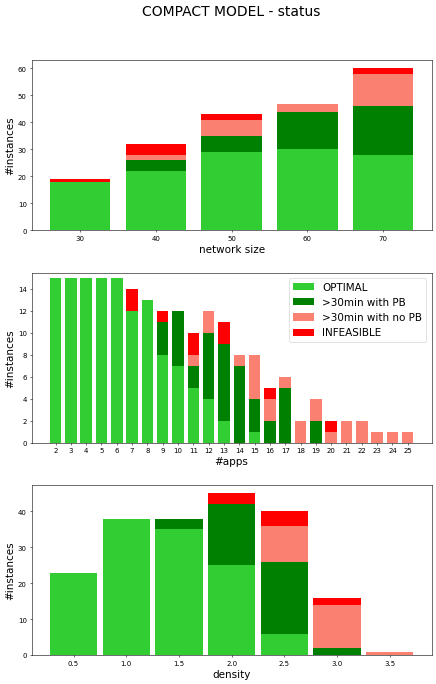

In [293]:
figure, axis = plt.subplots(3, 1)
figure.set_dpi(50)
figure.set_size_inches((10,14))

figure.suptitle('COMPACT MODEL - status', fontsize=20)

y1 = df_CM_by_network['#cm_optimal'].to_numpy()
y2 = df_CM_by_network['#cm_limit_primal'].to_numpy()
y3 = df_CM_by_network['#cm_limit_inf'].to_numpy()
y4 = df_CM_by_network['#cm_infeasible'].to_numpy()

axis[0].bar(network_sizes, y1, width=8.0, color='limegreen', label='OPTIMAL')
axis[0].bar(network_sizes, y2, bottom=y1, width=8.0, color='green', label='>30min with PB')
axis[0].bar(network_sizes, y3, bottom=y1+y2, width=8.0, color='salmon', label='>30min with no PB')
axis[0].bar(network_sizes, y4, bottom=y1+y2+y3, width=8.0, color='red', label='INFEASIBLE')
axis[0].set_xlabel("network size", fontsize=15)
axis[0].set_xticks(network_sizes)
axis[0].set_ylabel("#instances", fontsize=15)

y5 = df_CM_by_app['#cm_optimal'].to_numpy()
y6 = df_CM_by_app['#cm_limit_primal'].to_numpy()
y7 = df_CM_by_app['#cm_limit_inf'].to_numpy()
y8 = df_CM_by_app['#cm_infeasible'].to_numpy()

axis[1].bar(app_count, y5, width=0.75, color='limegreen', label='OPTIMAL')
axis[1].bar(app_count, y6, bottom=y5, width=0.75, color='green', label='>30min with PB')
axis[1].bar(app_count, y7, bottom=y5+y6, width=0.75, color='salmon', label='>30min with no PB')
axis[1].bar(app_count, y8, bottom=y5+y6+y7, width=0.75, color='red', label='INFEASIBLE')
axis[1].set_xlabel("#apps", fontsize=15)
axis[1].set_ylim((0,15.5))
axis[1].legend(loc='upper right', fontsize=15)
axis[1].set_ylabel("#instances", fontsize=15)
axis[1].set_xticks(app_count)#, fontsize=8)


y9 = df_CM_by_density['#cm_optimal'].to_numpy()
y10 = df_CM_by_density['#cm_limit_primal'].to_numpy()
y11 = df_CM_by_density['#cm_limit_inf'].to_numpy()
y12 = df_CM_by_density['#cm_infeasible'].to_numpy()

width = 0.45
axis[2].bar(densitities, y9, width=width, color='limegreen', label='OPTIMAL')
axis[2].bar(densitities, y10, bottom=y9, width=width, color='green', label='>30min with PB')
axis[2].bar(densitities, y11, bottom=y9+y10, width=width, color='salmon', label='>30min with no PB')
axis[2].bar(densitities, y12, bottom=y9+y10+y11, width=width, color='red', label='INFEASIBLE')
axis[2].set_xlabel("density", fontsize=15)
axis[2].set_ylabel("#instances", fontsize=15)
axis[2].set_xticks(densitities)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=None, hspace=0.25)
plt.savefig('output_images/compact_status.png', dpi=500)
plt.show()

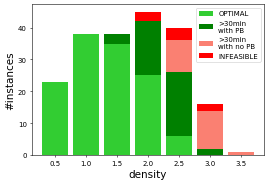

In [294]:
plt.figure(dpi=50)

width = 0.42
plt.bar(densitities, y9, width=width, color='limegreen', label='OPTIMAL')
plt.bar(densitities, y10, bottom=y9, width=width, color='green', label='>30min\nwith PB')
plt.bar(densitities, y11, bottom=y9+y10, width=width, color='salmon', label='>30min\nwith no PB')
plt.bar(densitities, y12, bottom=y9+y10+y11, width=width, color='red', label='INFEASIBLE')
plt.xlabel("density", fontsize=15)
plt.ylabel("#instances", fontsize=15)
plt.xticks(densitities)
plt.legend(fontsize=10)

plt.savefig('output_images/compact_status_density.png', dpi=300)
plt.show()

In [295]:
df_CM_by_app = df_CM.groupby(['#apps','compact_status']).agg({
    'compact_time': ['count', 'min', 'mean', 'std', 'max']
})
df_CM_by_app[('compact_time','min')] = list(map(lambda x: round(x,2),df_CM_by_app[('compact_time','min')].to_list()))
df_CM_by_app[('compact_time','mean')] = list(map(lambda x: round(x,2),df_CM_by_app[('compact_time','mean')].to_list()))
df_CM_by_app[('compact_time','std')] = list(map(lambda x: round(x,2),df_CM_by_app[('compact_time','std')].to_list()))
df_CM_by_app[('compact_time','max')] = list(map(lambda x: round(x,2),df_CM_by_app[('compact_time','max')].to_list()))
df_CM_by_app[('compact_time','std')].fillna("", inplace=True)

#df_CM_by_app

In [296]:
df_CM_by_density = df_CM.groupby(['density','compact_status']).agg({
    'compact_time': ['count', 'min', 'mean', 'std', 'max']
})
df_CM_by_density[('compact_time','min')] = list(map(lambda x: round(x,2),df_CM_by_density[('compact_time','min')].to_list()))
df_CM_by_density[('compact_time','mean')] = list(map(lambda x: round(x,2),df_CM_by_density[('compact_time','mean')].to_list()))
df_CM_by_density[('compact_time','std')] = list(map(lambda x: round(x,2),df_CM_by_density[('compact_time','std')].to_list()))
df_CM_by_density[('compact_time','max')] = list(map(lambda x: round(x,2),df_CM_by_density[('compact_time','max')].to_list()))
df_CM_by_density[('compact_time','std')].fillna("", inplace=True)

df_CM_by_density

compact_time                            \
                                        count      min     mean     std   
density compact_status                                                    
0.5     OPTIMAL                            23     0.02     0.48    0.56   
1.0     OPTIMAL                            38     0.04     9.13   34.08   
1.5     OPTIMAL                            35     0.45    45.23  115.22   
        TIME_LIMIT_>30min_primal            3  1800.03  1800.03     0.0   
2.0     INFEASIBLE                          3     0.74     1.37    0.74   
        OPTIMAL                            25     0.52   209.34  332.79   
        TIME_LIMIT_>30min_primal           17  1800.02  1800.05    0.03   
2.5     INFEASIBLE                          4     0.38    20.29   30.33   
        OPTIMAL                             6     8.27   363.74  364.27   
        TIME_LIMIT_>30min_inf              10  1800.03  1800.04    0.02   
        TIME_LIMIT_>30min_primal           20  1800.02  1800.05    0.03   
3.0     INFEASIBLE                          2    10.17    11.59    2.01   
        TIME_LIMIT_>30min_inf              12  1800.02  1800.08    0.06   
        TIME_LIMIT_>30min_primal            2  1800.04  1800.05    0.01   
3.5     TIME_LIMIT_>30min_inf               1  1800.04  1800.04           

                                           
                                      max  
density compact_status                     
0.5     OPTIMAL                      1.95  
1.0     OPTIMAL                    207.09  
1.5     OPTIMAL                    607.91  
        TIME_LIMIT_>30min_primal  1800.04  
2.0     INFEASIBLE                   2.18  
        OPTIMAL                   1499.80  
        TIME_LIMIT_>30min_primal  1800.11  
2.5     INFEASIBLE                  65.02  
        OPTIMAL                   1004.15  
        TIME_LIMIT_>30min_inf     1800.08  
        TIME_LIMIT_>30min_primal  1800.13  
3.0     INFEASIBLE                  13.02  
        TIME_LIMIT_>30min_inf     1800.21  
        TIME_LIMIT_>30min_primal  1800.06  
3.5     TIME_LIMIT_>30min_inf     1800.04

In [297]:
df.drop(columns=["compact_#nodes"], axis=1, inplace=True) # togliamo compact_#nodes tanto non lo analizzo

/var/folders/pg/zj5j0p614fq_84l8hsgr_40h0000gn/T/ipykernel_2690/592557317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["compact_#nodes"], axis=1, inplace=True) # togliamo compact_#nodes tanto non lo analizzo


### ANALISI - CG basic

In [298]:
columns_to_consider = ["ID", "nw_size", "#apps", "#msvcs", "density", "rnr_z", "compact_status", "compact_z*", "compact_time", "CG_status", "CG_#iter", "CG_LR_bound",	"CG_time", "CG_int_sol"]
df_CG = df[columns_to_consider]

In [299]:
df_CG.shape

(201, 14)

In [300]:
#df_CG

In [301]:
df_CG.loc[(df['rnr_z'] > df['CG_LR_bound'])]

,ID,nw_size,#apps,#msvcs,density,rnr_z,compact_status,compact_z*,compact_time,CG_status,CG_#iter,CG_LR_bound,CG_time,CG_int_sol
10,10,30,5,49,2.0,1728.451419,OPTIMAL,1791.0,0.728,GAP,15.0,1728.094445,3.943,NaN
263,263,60,2,24,0.5,928.563469,OPTIMAL,933.0,0.295,GAP,6.0,927.900803,2.205,NaN
269,269,60,4,42,1.0,1646.207166,OPTIMAL,1685.0,1.144,GAP,14.0,1645.634699,5.919,NaN
349,349,70,2,12,0.5,352.936782,OPTIMAL,353.0,0.197,GAP,2.0,352.724138,0.922,NaN
353,353,70,3,26,0.5,890.169068,OPTIMAL,902.0,0.438,GAP,9.0,889.576874,5.576,NaN


In [302]:
df_CG_by_network_inf = df.loc[(df['CG_status'] == "INF")].groupby(['nw_size']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
#display(df_CG_by_network_inf)

# plottati
df_CG_by_network = df.loc[(df['CG_status'] == "GAP")].groupby(['nw_size']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
display(df_CG_by_network)

df_CG_by_app_inf = df.loc[(df['CG_status'] == "INF")].groupby(['#apps']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
#display(df_CG_by_app_inf)

# plottati
df_CG_by_app = df.loc[(df['CG_status'] == "GAP")].groupby(['#apps']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
display(df_CG_by_app)

app_count_2 = sorted(list(df.loc[(df['CG_status'] == "GAP")]['#apps'].unique()))

df_CG_by_density_inf = df.loc[(df['CG_status'] == "INF")].groupby(['density']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
#display(df_CG_by_density_inf)

# plottati
df_CG_by_density = df.loc[(df['CG_status'] == "GAP")].groupby(['density']).agg({
    'CG_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std']
})
display(df_CG_by_density)

densities = sorted(list(df.loc[(df['CG_status'] == "GAP")]['density'].unique()))

CG_status CG_time                                 
            count     min      max        mean         std
nw_size                                                   
30             19   0.196   22.443    6.152895    6.552785
40             29   0.538   82.185   21.661241   22.123016
50             40   0.108  172.976   38.099775   41.998253
60             47   0.342  343.894   64.977170   72.534740
70             57   0.317  642.733  125.484351  136.854967

CG_status  CG_time                                 
          count      min      max        mean         std
#apps                                                    
2            15    0.108    2.205    0.749400    0.614790
3            15    0.256   16.766    4.811533    4.983511
4            15    0.882   54.582    9.110067   13.407163
5            15    1.202   22.443   10.002267    6.468196
6            15    3.464   26.396   14.029667    7.098352
7            13    9.419   33.916   18.069615    8.020193
8            13    6.443   51.005   19.189769   13.479236
9            11   12.660   68.659   39.734455   17.225987
10           12   17.240  118.085   57.169167   32.967723
11            9   15.274  172.976   69.372778   50.128757
12           12   40.623  135.717   80.234250   33.908321
13            9   52.948  159.898   94.877111   40.592921
14            8   73.800  159.205  124.462250   34.265611
15            8   38.525  488.826  199.772000  148.653230
16            5  108.253  284.224  197.809000   66.754824
17            6   71.826  231.756  150.005000   59.975771
19            4   93.032  354.350  223.885500  109.239693
20            1  410.837  410.837  410.837000         NaN
21            2  250.129  642.733  446.431000  277.612951
22            2  209.335  309.189  259.262000   70.607441
23            1  323.635  323.635  323.635000         NaN
24            1  322.173  322.173  322.173000         NaN

CG_status  CG_time                                 
            count      min      max        mean         std
density                                                    
0.5            23    0.108   10.013    2.483609    2.886906
1.0            38    0.256   54.582   10.134605   10.891437
1.5            38    3.005   89.315   27.852368   22.866630
2.0            43    3.464  227.982   65.818442   54.609054
2.5            38   12.125  642.733  143.626816  130.359308
3.0            11   68.216  410.837  232.522636  122.244897
3.5             1  129.218  129.218  129.218000         NaN

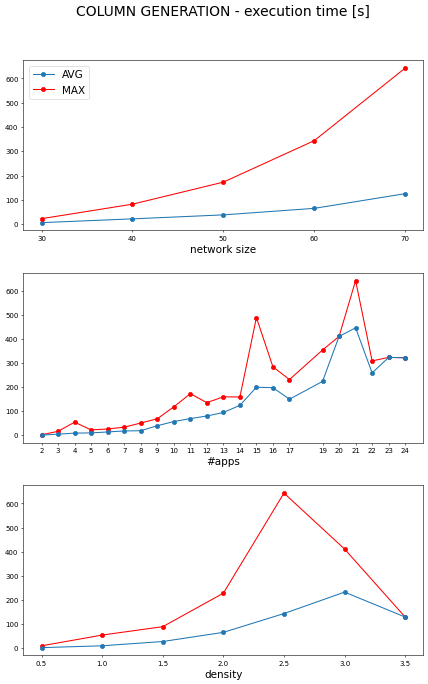

In [303]:
figure, axis = plt.subplots(3)
figure.set_dpi(50)
figure.set_size_inches((10,14))

figure.suptitle('COLUMN GENERATION - execution time [s]', fontsize=20)

axis[0].plot(network_sizes, df_CG_by_network[("CG_time", "mean")].to_list(), label = "AVG", marker='o')
axis[0].plot(network_sizes, df_CG_by_network[("CG_time", "max")].to_list(), label = "MAX", color='red', marker='o')
axis[0].legend(fontsize=15)
axis[0].set_xlabel("network size", fontsize=15)
axis[0].set_xticks(network_sizes)


axis[1].plot(app_count_2, df_CG_by_app[("CG_time", "max")].to_list(), label = "MAX", color='red', marker='o')
axis[1].plot(app_count_2, df_CG_by_app[("CG_time", "mean")].to_list(), label = "AVG", marker='o')
axis[1].set_xlabel("#apps", fontsize=15)
axis[1].set_xticks(ticks=app_count_2)


axis[2].plot(densitities, df_CG_by_density[("CG_time", "max")].to_list(), label = "MAX", color='red', marker='o')
axis[2].plot(densitities, df_CG_by_density[("CG_time", "mean")].to_list(), label = "AVG", marker='o')
axis[2].set_xlabel("density", fontsize=15)
axis[2].set_xticks(ticks=densities)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=None, hspace=0.25)
plt.savefig('output_images/cg_times.png', dpi=500)
plt.show()

In [304]:
df_CG.loc[df_CG['CG_int_sol'].notna()]

,ID,nw_size,#apps,#msvcs,density,rnr_z,compact_status,compact_z*,compact_time,CG_status,CG_#iter,CG_LR_bound,CG_time,CG_int_sol
174,174,50,2,16,0.5,629.519195,OPTIMAL,667.0,0.198,GAP,1.0,667.0,0.577,667.0
175,175,50,2,10,0.5,394.000000,OPTIMAL,394.0,0.018,GAP,1.0,394.0,0.108,394.0
261,261,60,2,14,0.5,449.157477,OPTIMAL,474.0,0.281,GAP,1.0,474.0,0.821,474.0
262,262,60,2,10,0.5,251.000000,OPTIMAL,251.0,0.082,GAP,1.0,251.0,0.342,251.0
348,348,70,2,10,0.5,454.253481,OPTIMAL,460.0,0.071,GAP,1.0,460.0,0.317,460.0


In [305]:
# compact INFEASIBLE                cg GAP          17,115,391              
# compact INFEASIBLE                cg INFEASIBLE   102,110,120,203,207,402 -> no guadagni in termini di tempo, non è bello far continuare il CG finchè non esce la dummy.
#                                                                             se fallisce il pricing invece va anche bene
# compact TIME_LIMIT_>30min_inf     cg GAP            
# compact TIME_LIMIT_>30min_inf     cg INFEASIBLE   223,396,417 -> non è bello far continuare il CG finchè non esce la dummy, ma ci guadagniamo in termini di tempo perchè compact ha time limit

#display(df_CG.loc[(df_CG['compact_status'] == "INFEASIBLE") | (df_CG['compact_status'] == "TIME_LIMIT_>30min_inf")])
print(df_CG.loc[(df_CG['compact_status'] == "INFEASIBLE") | (df_CG['compact_status'] == "TIME_LIMIT_>30min_inf")].shape)

(32, 14)


In [306]:
df_CG = df_CG.loc[(df_CG['CG_status'] == "GAP")]

df_CG['CG_gap_wrt_compact_z*_or_primal'] = np.where((df_CG['compact_z*'] == "inf") | (df_CG['compact_z*'].isna()), 
                                                    "", (100 * (df_CG['compact_z*'].astype(float) - df_CG['CG_LR_bound']) / df_CG['compact_z*'].astype(float)))

df_CG['rnr_gap_wrt_compact_z*_or_primal'] = np.where((df_CG['compact_z*'] == "inf") | (df_CG['compact_z*'].isna()), 
                                                    "", (100 * (df_CG['compact_z*'].astype(float) - df_CG['rnr_z']) / df_CG['compact_z*'].astype(float)))

df_CG['CG_bound_perc_increase_wrt_rnr'] = 100 * (df_CG['CG_LR_bound'] - df_CG['rnr_z']) / df_CG['rnr_z']

#display(df_CG)

In [307]:
df_CG_by_network = df_CG.loc[(df_CG['CG_gap_wrt_compact_z*_or_primal'] != "")]
df_CG_by_network['CG_gap_wrt_compact_z*_or_primal'] = df_CG_by_network['CG_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_network['rnr_gap_wrt_compact_z*_or_primal'] = df_CG_by_network['rnr_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_network = df_CG_by_network.groupby(['nw_size']).agg({
    'CG_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std'],
    'rnr_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std']
})
#display(df_CG_by_network)

df_CG_by_network2 = df_CG.groupby(['nw_size']).agg({
    'CG_bound_perc_increase_wrt_rnr': ['count', 'min', 'max', 'mean', 'std']
})
#display(df_CG_by_network2)

x_ = np.array(network_sizes)

##########

df_CG_by_app = df_CG.loc[(df_CG['CG_gap_wrt_compact_z*_or_primal'] != "")]
x1 = np.array(sorted(list(df_CG_by_app['#apps'].unique())))
df_CG_by_app['CG_gap_wrt_compact_z*_or_primal'] = df_CG_by_app['CG_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_app['rnr_gap_wrt_compact_z*_or_primal'] = df_CG_by_app['rnr_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_app = df_CG_by_app.groupby(['#apps']).agg({
    'CG_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std'],
    'rnr_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std']
})
#display(df_CG_by_app)
df_CG_by_app2 = df_CG.groupby(['#apps']).agg({
    'CG_bound_perc_increase_wrt_rnr': ['count', 'min', 'max', 'mean', 'std']
})
x2 = np.array(sorted(list(df_CG['#apps'].unique())))
#display(df_CG_by_app2)

##########

df_CG_by_density = df_CG.loc[(df_CG['CG_gap_wrt_compact_z*_or_primal'] != "")]
x__ = np.array(sorted(list(df_CG_by_density['density'].unique())))
df_CG_by_density['CG_gap_wrt_compact_z*_or_primal'] = df_CG_by_density['CG_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_density['rnr_gap_wrt_compact_z*_or_primal'] = df_CG_by_density['rnr_gap_wrt_compact_z*_or_primal'].astype(float)
df_CG_by_density = df_CG_by_density.groupby(['density']).agg({
    'CG_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std'],
    'rnr_gap_wrt_compact_z*_or_primal': ['count', 'min', 'max', 'mean', 'std']
})
#display(df_CG_by_density)

df_CG_by_density2 = df_CG.groupby(['density']).agg({
    'CG_bound_perc_increase_wrt_rnr': ['count', 'min', 'max', 'mean', 'std']
})
x__2 = np.array(sorted(list(df_CG['density'].unique())))
#display(df_CG_by_density2)

/var/folders/pg/zj5j0p614fq_84l8hsgr_40h0000gn/T/ipykernel_2690/423412593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CG_by_network['CG_gap_wrt_compact_z*_or_primal'] = df_CG_by_network['CG_gap_wrt_compact_z*_or_primal'].astype(float)
/var/folders/pg/zj5j0p614fq_84l8hsgr_40h0000gn/T/ipykernel_2690/423412593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CG_by_network['rnr_gap_wrt_compact_z*_or_primal'] = df_CG_by_network['rnr_gap_wrt_compact_z*_or_primal'].astype(float)
/var/folders/pg/zj

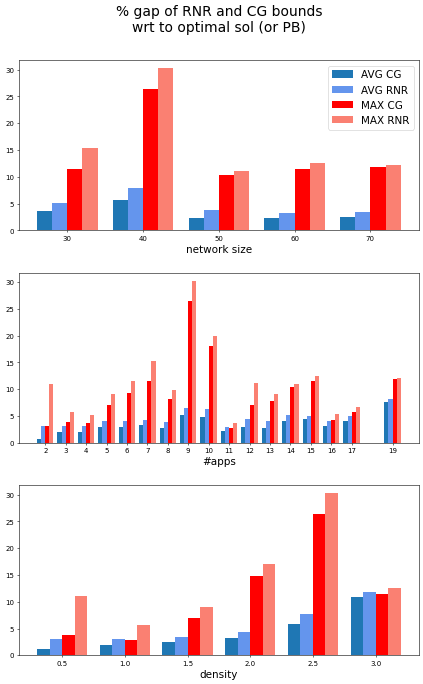

In [308]:
figure, axis = plt.subplots(3)
figure.set_dpi(50)
figure.set_size_inches((10,14))

figure.suptitle('% gap of RNR and CG bounds\nwrt to optimal sol (or PB)', fontsize=20)

bar_width = 2

axis[0].bar(x_ - 1.5*bar_width, df_CG_by_network[("CG_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG CG", color='tab:blue')
axis[0].bar(x_ - 0.5*bar_width, df_CG_by_network[("rnr_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG RNR", color='cornflowerblue')
axis[0].bar(x_ + 0.5*bar_width, df_CG_by_network[("CG_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX CG", color='red')
axis[0].bar(x_ + 1.5*bar_width, df_CG_by_network[("rnr_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX RNR", color='salmon')
axis[0].legend(fontsize=15)
axis[0].set_xlabel("network size", fontsize=15)
axis[0].set_xticks(network_sizes)

###

bar_width = 0.2

axis[1].bar(x1 - 1.5*bar_width, df_CG_by_app[("CG_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG CG", color='tab:blue')
axis[1].bar(x1 - 0.5*bar_width, df_CG_by_app[("rnr_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG RNR", color='cornflowerblue')
axis[1].bar(x1 + 0.5*bar_width, df_CG_by_app[("CG_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX CG", color='red')
axis[1].bar(x1 + 1.5*bar_width, df_CG_by_app[("rnr_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX RNR", color='salmon')
axis[1].set_xlabel("#apps", fontsize=15)
axis[1].set_xticks(x1)

###

bar_width = 0.1

axis[2].bar(x__ - 1.5*bar_width, df_CG_by_density[("CG_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG CG", color='tab:blue')
axis[2].bar(x__ - 0.5*bar_width, df_CG_by_density[("rnr_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG RNR", color='cornflowerblue')
axis[2].bar(x__ + 0.5*bar_width, df_CG_by_density[("CG_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX CG", color='red')
axis[2].bar(x__ + 1.5*bar_width, df_CG_by_density[("rnr_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX RNR", color='salmon')
axis[2].set_xlabel("density", fontsize=15)
axis[2].set_xticks(x__)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=None, hspace=0.25)
plt.savefig('output_images/cg_gaps.png', dpi=500)
plt.show()

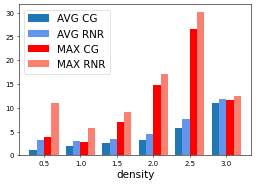

In [309]:
plt.figure(dpi=50)

bar_width = 0.1

plt.bar(x__ - 1.5*bar_width, df_CG_by_density[("CG_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG CG", color='tab:blue')
plt.bar(x__ - 0.5*bar_width, df_CG_by_density[("rnr_gap_wrt_compact_z*_or_primal", "mean")].to_list(), width=bar_width, label = "AVG RNR", color='cornflowerblue')
plt.bar(x__ + 0.5*bar_width, df_CG_by_density[("CG_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX CG", color='red')
plt.bar(x__ + 1.5*bar_width, df_CG_by_density[("rnr_gap_wrt_compact_z*_or_primal", "max")].to_list(), width=bar_width, label = "MAX RNR", color='salmon')

#plt.title('% gap of RNR and CG bounds\nwrt to optimal sol (or PB)', fontsize=20)
plt.xlabel("density", fontsize=15)
#plt.ylim((0,15.5))
plt.legend(fontsize=15)
plt.xticks(x__)

plt.savefig('output_images/cg_gaps_density.png', dpi=300)
plt.show()

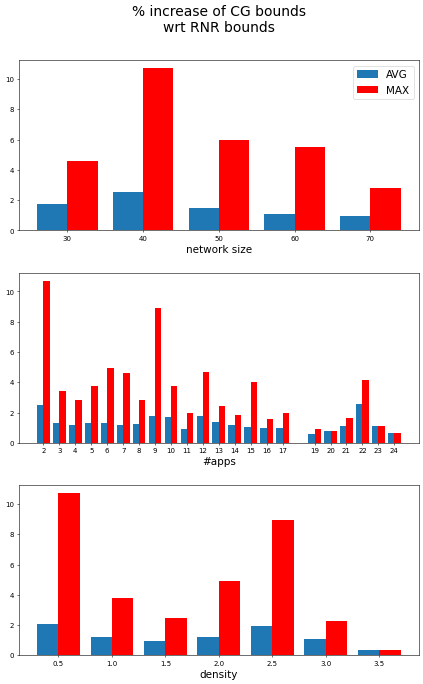

In [310]:
figure, axis = plt.subplots(3)
figure.set_dpi(50)
figure.set_size_inches((10,14))

figure.suptitle('% increase of CG bounds\nwrt RNR bounds', fontsize=20)
bar_width = 4

axis[0].bar(x_ - 0.5*bar_width, df_CG_by_network2[("CG_bound_perc_increase_wrt_rnr", "mean")].to_list(), width=bar_width, label = "AVG", color='tab:blue')
axis[0].bar(x_ + 0.5*bar_width, df_CG_by_network2[("CG_bound_perc_increase_wrt_rnr", "max")].to_list(), width=bar_width, label = "MAX", color='red')
axis[0].legend(fontsize=15)
axis[0].set_xlabel("network size", fontsize=15)
axis[0].set_xticks(network_sizes)

bar_width = 0.4

axis[1].bar(x2 - 0.5*bar_width, df_CG_by_app2[("CG_bound_perc_increase_wrt_rnr", "mean")].to_list(), width=bar_width, label = "AVG", color='tab:blue')
axis[1].bar(x2 + 0.5*bar_width, df_CG_by_app2[("CG_bound_perc_increase_wrt_rnr", "max")].to_list(), width=bar_width, label = "MAX", color='red')
axis[1].set_xlabel("#apps", fontsize=15)
axis[1].set_xticks(x2)

bar_width = 0.2

axis[2].bar(x__2 - 0.5*bar_width, df_CG_by_density2[("CG_bound_perc_increase_wrt_rnr", "mean")].to_list(), width=bar_width, label = "AVG", color='tab:blue')
axis[2].bar(x__2 + 0.5*bar_width, df_CG_by_density2[("CG_bound_perc_increase_wrt_rnr", "max")].to_list(), width=bar_width, label = "MAX", color='red')
axis[2].set_xlabel("density", fontsize=15)
axis[2].set_xticks(x__2)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=None, hspace=0.25)
plt.savefig('output_images/cg_increase.png', dpi=500)
plt.show()

### ANALISI - CG with heuristic pricing

In [311]:
# in CG_heuristic.txt dò 0.05 secondi per ogni pricing 

In [312]:
columns_to_consider = ["ID", "nw_size", "#apps", "#msvcs", "rnr_z", "compact_status", "compact_z*", "compact_time", 
                       "CG_status", "CG_#iter", "CG_LR_bound",	"CG_time", "CG_int_sol",
                       "CGh_status", "CGh_#iter", "CGh_LR_bound",	"CGh_time", "CGh_int_sol"]
df_CGh = df[columns_to_consider]

df['%decrease_heuristic'] = 100 * (df["CG_time"] - df["CGh_time"]) / df["CG_time"]

/var/folders/pg/zj5j0p614fq_84l8hsgr_40h0000gn/T/ipykernel_2690/1428465486.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['%decrease_heuristic'] = 100 * (df["CG_time"] - df["CGh_time"]) / df["CG_time"]


In [313]:
#df_CGh

In [314]:
# plottati
df_CGh_by_app = df.loc[(df['CG_status'] == "GAP")].groupby(['#apps']).agg({
    'CG_status': ['count'],
    'CGh_status': ['count'],
    'CG_time': ['min', 'max', 'mean', 'std'],
    'CGh_time': ['min', 'max', 'mean', 'std'],
    '%decrease_heuristic': ['min', 'max', 'mean', 'std'],
})
display(df_CGh_by_app)

app_count_2 = sorted(list(df.loc[(df['CG_status'] == "GAP")]['#apps'].unique()))

CG_status CGh_status  CG_time                                  CGh_time  \
          count      count      min      max        mean         std      min   
#apps                                                                           
2            15         15    0.108    2.205    0.749400    0.614790    0.153   
3            15         15    0.256   16.766    4.811533    4.983511    0.357   
4            15         15    0.882   54.582    9.110067   13.407163    1.281   
5            15         15    1.202   22.443   10.002267    6.468196    1.474   
6            15         15    3.464   26.396   14.029667    7.098352    3.376   
7            13         13    9.419   33.916   18.069615    8.020193    8.730   
8            13         13    6.443   51.005   19.189769   13.479236    4.902   
9            11         11   12.660   68.659   39.734455   17.225987   10.748   
10           12         12   17.240  118.085   57.169167   32.967723   15.693   
11            9          9   15.274  172.976   69.372778   50.128757   13.677   
12           12         12   40.623  135.717   80.234250   33.908321   36.333   
13            9          9   52.948  159.898   94.877111   40.592921   43.048   
14            8          8   73.800  159.205  124.462250   34.265611   66.109   
15            8          8   38.525  488.826  199.772000  148.653230   39.897   
16            5          5  108.253  284.224  197.809000   66.754824  120.602   
17            6          6   71.826  231.756  150.005000   59.975771   63.328   
19            4          4   93.032  354.350  223.885500  109.239693   77.048   
20            1          1  410.837  410.837  410.837000         NaN  426.585   
21            2          2  250.129  642.733  446.431000  277.612951  214.227   
22            2          2  209.335  309.189  259.262000   70.607441  174.876   
23            1          1  323.635  323.635  323.635000         NaN  287.505   
24            1          1  322.173  322.173  322.173000         NaN  290.763   

                                       %decrease_heuristic             \
           max        mean         std                 min        max   
#apps                                                                   
2        2.471    0.800133    0.665143          -50.000000  21.938776   
3       16.765    4.531733    5.192239          -39.453125  34.526507   
4       57.479    9.187933   14.018707          -48.299320  27.613147   
5       21.642    9.342467    6.005976          -22.628952  27.039740   
6       27.273   12.740133    6.570215          -11.788335  28.863473   
7       30.735   17.135923    8.063984          -17.376252  27.310575   
8       40.601   16.970000   11.326749           -2.665857  27.590059   
9       61.171   38.260091   16.320112           -8.886821  15.102686   
10     120.654   54.427750   32.635821           -8.454014  24.401696   
11     180.112   68.205000   52.338011           -4.450158  17.232273   
12     146.494   76.619417   36.776487          -15.684819  17.005856   
13     143.200   83.666000   38.096430           -1.342675  26.215656   
14     154.348  116.431750   34.421524           -4.055456  15.950391   
15     538.740  198.976750  161.618459          -10.976025  15.223846   
16     275.863  179.137200   58.086916          -11.407536  29.916836   
17     194.923  135.058000   50.412661           -6.266803  19.320937   
19     309.901  192.047250   96.098564           11.165215  17.841705   
20     426.585  426.585000         NaN           -3.833150  -3.833150   
21     631.320  422.773500  294.929289            1.775698  14.353394   
22     298.410  236.643000   87.351729            3.486217  16.461175   
23     287.505  287.505000         NaN           11.163811  11.163811   
24     290.763  290.763000         NaN            9.749420   9.749420   

                             
            mean        std  
#apps                        
2      -9.556496  18.265143  
3       8.820543  21.041614  
4   

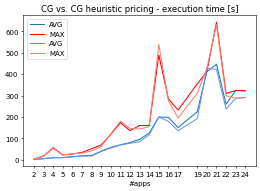

In [315]:
plt.figure(dpi=50)

plt.plot(app_count_2, df_CGh_by_app[("CG_time", "mean")].to_list(), label = "AVG", color='tab:blue')
plt.plot(app_count_2, df_CGh_by_app[("CG_time", "max")].to_list(), label = "MAX", color='red')
plt.plot(app_count_2, df_CGh_by_app[("CGh_time", "mean")].to_list(), label = "AVG", color='cornflowerblue')
plt.plot(app_count_2, df_CGh_by_app[("CGh_time", "max")].to_list(), label = "MAX", color='salmon')
plt.legend()
plt.title("CG vs. CG heuristic pricing - execution time [s]")
plt.xlabel("#apps")
plt.xticks(app_count_2)

plt.savefig('output_images/cg_heuristic_time_by_app.png', dpi=200)
plt.show()


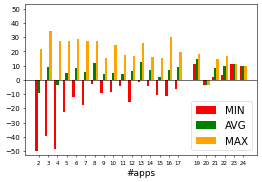

In [316]:
app_count_2 = np.array(app_count_2)

bar_width = 0.25

plt.figure(dpi=50)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.bar(app_count_2 - bar_width, df_CGh_by_app[("%decrease_heuristic", "min")].to_list(), width=bar_width, color='red', label='MIN')
plt.bar(app_count_2, df_CGh_by_app[("%decrease_heuristic", "mean")].to_list(), width=bar_width, color='green', label='AVG')
plt.bar(app_count_2 + bar_width, df_CGh_by_app[("%decrease_heuristic", "max")].to_list(), width=bar_width,color='orange', label='MAX')

# Customize the plot
plt.xlabel('#apps',fontsize=13)
plt.xticks(app_count_2, fontsize=8)
plt.ylim((-53,53))
plt.yticks(list(range(-50,60,10)))
plt.legend(loc='lower right',fontsize=15)

plt.savefig('output_images/cg_heuristic_barplot.png', dpi=300)
plt.show()

### ANALISI - Matheuristics

In [317]:
# we remove the infeasible instances by compact or cg, we will not consider them anymore
print("len before : ", len(df))
df = df[(df['CG_status'] == "GAP") & (df['CG_int_sol'].isna())]
print("len after : ", len(df))

len before :  201
len after :  187


In [318]:
needed_primal_indexes = dict()
for size in network_sizes:
    needed_primal_indexes[size] = df.loc[(df['nw_size'] == size)]['ID'].tolist()
for k,v in needed_primal_indexes.items():
    print(k,v)
# già dumpati
# with open('needed_primal_indexes.pickle', 'wb') as f:
#    pickle.dump(needed_primal_indexes, f, protocol=pickle.HIGHEST_PROTOCOL)

30 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]
40 [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 111, 112, 113, 115, 117, 118, 119, 122]
50 [176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 208, 209, 210, 212, 213, 215, 216, 221]
60 [263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 307, 308, 312, 322]
70 [349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 399, 400, 401, 403, 406, 407, 408, 412, 416]


In [319]:
# credo sia meglio toglierle perchè non sono insuccessi per colpa dell'algoritmo
print("len before : ", len(df))
df = df[df['compact_status'] != "INFEASIBLE"]
print("len after : ", len(df))

len before :  187
len after :  184


In [320]:
#df.columns

In [321]:
columns_to_consider = [
       'ID', 'nw_size', '#apps', '#msvcs', 'compact_time', 'compact_status', 'compact_z*', 'CG_time', 
       'DRMP_status', 'DRMP_primal', 'DRMP_time', 
       'PD_status','PD_primal', 'PD_time', 
       'hr_time', 'hr_status', 'hr_solver_status','hr_primal'
]
df = df[columns_to_consider]
apps = np.array(sorted(list(df['#apps'].unique())))

In [322]:
#df

In [323]:
df_drmp_pd_hr = df.groupby('#apps').agg({
    '#apps': ['count'],
    'DRMP_time': ['min', 'max', 'mean', 'std'], 
    'PD_time': ['min', 'max', 'mean', 'std'],
    'hr_time': ['min', 'max', 'mean', 'std'],
})
df_drmp_pd_hr['#DRMP_success'] = df.groupby(['#apps']).apply(lambda group: (group['DRMP_status'] == "success").sum()).reset_index(name='count_drmp_success')['count_drmp_success'].to_list()
df_drmp_pd_hr['#DRMP_fail'] = df.groupby(['#apps']).apply(lambda group: (group['DRMP_status'] != "success").sum()).reset_index(name='count_drmp_fail')['count_drmp_fail'].to_list()
df_drmp_pd_hr['#PD_success'] = df.groupby(['#apps']).apply(lambda group: (group['PD_status'] == "success").sum()).reset_index(name='count_pd_success')['count_pd_success'].to_list()
df_drmp_pd_hr['#PD_fail'] = df.groupby(['#apps']).apply(lambda group: (group['PD_status'] != "success").sum()).reset_index(name='count_pd_fail')['count_pd_fail'].to_list()
df_drmp_pd_hr['#HR_success'] = df.groupby(['#apps']).apply(lambda group: (group['hr_status'] == "success").sum()).reset_index(name='count_hr_success')['count_hr_success'].to_list()
df_drmp_pd_hr['#HR_fail'] = df.groupby(['#apps']).apply(lambda group: (group['hr_status'] != "success").sum()).reset_index(name='count_hr_fail')['count_hr_fail'].to_list()

#display(df_drmp_pd_hr)

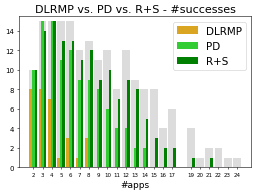

In [324]:
plt.figure(figsize=(6, 4), dpi=50)

y1 = df_drmp_pd_hr['#DRMP_success'].to_numpy()
y2 = df_drmp_pd_hr['#DRMP_fail'].to_numpy()
y3 = df_drmp_pd_hr['#PD_success'].to_numpy()
y4 = df_drmp_pd_hr['#PD_fail'].to_numpy()
y5 = df_drmp_pd_hr['#HR_success'].to_numpy()
y6 = df_drmp_pd_hr['#HR_fail'].to_numpy()

bar_width = 0.28

plt.bar(apps - bar_width,   y1, width=bar_width, label='DLRMP',  color='goldenrod')
plt.bar(apps - bar_width,   y2, width=bar_width, bottom=y1,     color='gainsboro')
plt.bar(apps,               y3, width=bar_width, label='PD',    color='limegreen')
plt.bar(apps,               y4, width=bar_width, bottom=y3,     color='gainsboro')
plt.bar(apps + bar_width,   y5, width=bar_width, label='R+S',    color='green')
plt.bar(apps + bar_width,   y6, width=bar_width, bottom=y5,     color='gainsboro')

plt.title("DLRMP vs. PD vs. R+S - #successes", fontsize=16)
plt.xlabel("#apps",fontsize=13)
plt.ylim((0,15.5))
plt.legend(loc='upper right', fontsize=15)
plt.xticks(apps, fontsize=8)

plt.savefig('output_images/matheuristics_successes.png', dpi=300)
plt.show()

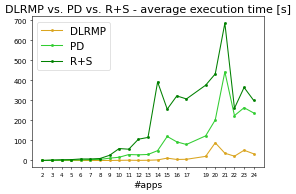

In [325]:
plt.figure(figsize=(6, 4), dpi=50)

plt.plot(apps, df_drmp_pd_hr[('DRMP_time','mean')].to_list(), label = "DLRMP", color='goldenrod', marker='.')
plt.plot(apps, df_drmp_pd_hr[('PD_time','mean')].to_list(), label = "PD", color='limegreen', marker='.')
plt.plot(apps, df_drmp_pd_hr[('hr_time','mean')].to_list(), label = "R+S", color='green', marker='.')

plt.legend(fontsize=15)
plt.title("DLRMP vs. PD vs. R+S - average execution time [s]", fontsize=16)
plt.xlabel("#apps", fontsize=13)
plt.xticks(ticks=apps, fontsize=8)

plt.savefig('output_images/matheuristics_time.png', dpi=300)
plt.show()

analizzare la qualità dei bound primali

In [326]:
#df

In [327]:
df.loc[(df['compact_status'] == "TIME_LIMIT_>30min_primal")].shape

(42, 18)

In [328]:
df.loc[(df['compact_status'] == "TIME_LIMIT_>30min_inf")].shape

(20, 18)

In [329]:
df.shape

(184, 18)

In [330]:
df = df.loc[(df['DRMP_status'] == "success") | (df['PD_status'] == "success") | (df['hr_status'] == "success")]

df['GAP_DRMP'] = np.where(df['compact_z*'] != "inf", 100 * (df['DRMP_primal'] - df['compact_z*'].astype(float)) / df['compact_z*'].astype(float), np.nan)
df['GAP_PD'] = np.where(df['compact_z*'] != "inf", 100 * (df['PD_primal'] - df['compact_z*'].astype(float)) / df['compact_z*'].astype(float), np.nan)
df['GAP_hr'] = np.where(df['compact_z*'] != "inf", 100 * (df['hr_primal'] - df['compact_z*'].astype(float)) / df['compact_z*'].astype(float), np.nan)

#display(df)

#### ANALISI DLRMP

In [331]:
df_drmp_success = df.loc[(df['DRMP_status'] == "success")]
df_drmp_success.shape

(31, 21)

In [332]:
# quando ha successo DRMP hanno sempre successo anche PD e HR
# DRMP non hai mai successo quando il solutore è in time limit e mai per più di 8 app
#df_drmp_success

In [333]:
df_drmp_success['GAP_DRMP'].mean(), df_drmp_success['GAP_PD'].mean(), df_drmp_success['GAP_hr'].mean()

(1.1375488361104866, 1.3541896524005335, 0.29739626678647746)

In [334]:
df_drmp_success.loc[(df_drmp_success['DRMP_primal'] < df_drmp_success['PD_primal'])]

,ID,nw_size,#apps,#msvcs,compact_time,compact_status,compact_z*,CG_time,DRMP_status,DRMP_primal,DRMP_time,PD_status,PD_primal,PD_time,hr_time,hr_status,hr_solver_status,hr_primal,GAP_DRMP,GAP_PD,GAP_hr
0,0,30,2,10,0.067,OPTIMAL,424.0,0.242,success,424.0,0.001,success,429.0,0.014,0.118,success,OPTIMAL,429.0,0.000000,1.179245,1.179245
2,2,30,2,23,0.209,OPTIMAL,960.0,0.619,success,964.0,0.001,success,990.0,0.044,0.250,success,OPTIMAL,966.0,0.416667,3.125000,0.625
177,177,50,3,23,0.202,OPTIMAL,756.0,1.394,success,761.0,0.001,success,779.0,0.423,0.613,success,OPTIMAL,763.0,0.661376,3.042328,0.925926
181,181,50,4,27,0.279,OPTIMAL,1226.0,1.409,success,1229.0,0.003,success,1249.0,0.178,0.423,success,OPTIMAL,1229.0,0.244698,1.876020,0.244698
186,186,50,6,44,2.843,OPTIMAL,1373.0,8.838,success,1398.0,0.008,success,1406.0,2.322,3.263,success,OPTIMAL,1389.0,1.820830,2.403496,1.165331
192,192,50,8,67,10.794,OPTIMAL,2302.0,19.101,success,2316.0,0.015,success,2396.0,3.760,7.147,success,OPTIMAL,2316.0,0.608167,4.083406,0.608167
263,263,60,2,24,0.295,OPTIMAL,933.0,2.205,success,935.0,0.002,success,949.0,0.120,0.540,success,OPTIMAL,933.0,0.214362,1.714898,0.0
264,264,60,3,22,0.798,OPTIMAL,891.0,6.621,success,906.0,0.002,success,923.0,0.667,1.543,success,OPTIMAL,893.0,1.683502,3.591470,0.224467
268,268,60,4,37,1.199,OPTIMAL,1501.0,5.893,success,1526.0,0.006,success,1528.0,0.540,2.244,success,OPTIMAL,1502.0,1.665556,1.798801,0.066622
270,270,60,5,32,2.315,OPTIMAL,1246.0,7.124,success,1246.0,0.005,success,1260.0,1.245,3.818,success,OPTIMAL,1260.0,0.000000,1.123596,1.123596


In [335]:
df_drmp_success.loc[(df_drmp_success['DRMP_primal'] < df_drmp_success['hr_primal'])]

,ID,nw_size,#apps,#msvcs,compact_time,compact_status,compact_z*,CG_time,DRMP_status,DRMP_primal,DRMP_time,PD_status,PD_primal,PD_time,hr_time,hr_status,hr_solver_status,hr_primal,GAP_DRMP,GAP_PD,GAP_hr
0,0,30,2,10,0.067,OPTIMAL,424.0,0.242,success,424.0,0.001,success,429.0,0.014,0.118,success,OPTIMAL,429.0,0.000000,1.179245,1.179245
2,2,30,2,23,0.209,OPTIMAL,960.0,0.619,success,964.0,0.001,success,990.0,0.044,0.250,success,OPTIMAL,966.0,0.416667,3.125000,0.625
177,177,50,3,23,0.202,OPTIMAL,756.0,1.394,success,761.0,0.001,success,779.0,0.423,0.613,success,OPTIMAL,763.0,0.661376,3.042328,0.925926
270,270,60,5,32,2.315,OPTIMAL,1246.0,7.124,success,1246.0,0.005,success,1260.0,1.245,3.818,success,OPTIMAL,1260.0,0.000000,1.123596,1.123596
274,274,60,6,42,0.442,OPTIMAL,1573.0,5.479,success,1573.0,0.003,success,1596.0,2.368,2.623,success,OPTIMAL,1596.0,0.000000,1.462174,1.462174


In [336]:
len(df_drmp_success.loc[(df_drmp_success['GAP_DRMP'] == 0.0)])

12

In [337]:
df_drmp_success_by_app = df_drmp_success.groupby('#apps').agg({
    '#apps': ['count'],
    'GAP_DRMP': ['min', 'mean', 'std', 'max']
})
df_drmp_success_by_app[('GAP_DRMP','min')] = list(map(lambda x: round(x,2),df_drmp_success_by_app[('GAP_DRMP','min')].to_list()))
df_drmp_success_by_app[('GAP_DRMP','mean')] = list(map(lambda x: round(x,2),df_drmp_success_by_app[('GAP_DRMP','mean')].to_list()))
df_drmp_success_by_app[('GAP_DRMP','std')] = list(map(lambda x: round(x,2),df_drmp_success_by_app[('GAP_DRMP','std')].to_list()))
df_drmp_success_by_app[('GAP_DRMP','max')] = list(map(lambda x: round(x,2),df_drmp_success_by_app[('GAP_DRMP','max')].to_list()))
df_drmp_success_by_app[('GAP_DRMP','std')].fillna("", inplace=True)

df_drmp_success_by_app

#apps GAP_DRMP                  
      count      min  mean   std   max
#apps                                 
2         8     0.00  0.08  0.16  0.42
3         8     0.00  1.67  1.87  5.52
4         7     0.00  1.38  1.83  5.23
5         1     0.00  0.00        0.00
6         3     0.00  2.59  3.06  5.96
7         1     0.17  0.17        0.17
8         3     0.61  1.22  0.53  1.55

#### ANALISI Pure Diving

In [338]:
df_pd_success = df.loc[(df['PD_status'] == "success")]
df_pd_success.shape

(107, 21)

In [339]:
# quando ha successo PD ha sempre successo anche HR, tranne 2 volte
# PD ha successo 8 volte in cui il solutore è in time limit primal su 42
#df_pd_success

In [340]:
df_pd_success['GAP_PD'].mean(), df_pd_success['GAP_hr'].mean()

(2.0538005705434514, 0.4741293466722156)

In [341]:
df_pd_success.loc[(df_pd_success['PD_primal'] < df_pd_success['hr_primal'])] # ha la meglio PD anche le volte che trova sol e hr no

,ID,nw_size,#apps,#msvcs,compact_time,compact_status,compact_z*,CG_time,DRMP_status,DRMP_primal,DRMP_time,PD_status,PD_primal,PD_time,hr_time,hr_status,hr_solver_status,hr_primal,GAP_DRMP,GAP_PD,GAP_hr
87,87,40,2,19,0.154,OPTIMAL,819.0,0.613,,NaN,0.001,success,819.0,0.068,0.225,success,OPTIMAL,828.0,NaN,0.000000,1.098901
289,289,60,11,89,5.027,OPTIMAL,3254.0,19.404,,NaN,0.040,success,3277.0,8.362,11.776,success,OPTIMAL,3281.0,NaN,0.706822,0.829748
351,351,70,3,21,0.531,OPTIMAL,758.0,3.314,,NaN,0.002,success,760.0,0.183,1.513,success,OPTIMAL,770.0,NaN,0.263852,1.583113
359,359,70,5,34,1.840,OPTIMAL,1613.0,10.013,,NaN,0.008,success,1614.0,1.944,6.930,success,OPTIMAL,1633.0,NaN,0.061996,1.239926


In [342]:
len(df_pd_success.loc[(df_pd_success['GAP_PD'] == 0.0)])

9

In [343]:
df_pd_success_by_app = df_pd_success.groupby('#apps').agg({
    '#apps': ['count'],
    'GAP_PD': ['min', 'mean', 'std', 'max']
})
df_pd_success_by_app[('GAP_PD','min')] = list(map(lambda x: round(x,2),df_pd_success_by_app[('GAP_PD','min')].to_list()))
df_pd_success_by_app[('GAP_PD','mean')] = list(map(lambda x: round(x,2),df_pd_success_by_app[('GAP_PD','mean')].to_list()))
df_pd_success_by_app[('GAP_PD','std')] = list(map(lambda x: round(x,2),df_pd_success_by_app[('GAP_PD','std')].to_list()))
df_pd_success_by_app[('GAP_PD','max')] = list(map(lambda x: round(x,2),df_pd_success_by_app[('GAP_PD','max')].to_list()))
df_pd_success_by_app[('GAP_PD','std')].fillna("", inplace=True)

df_pd_success_by_app

#apps GAP_PD                  
      count    min  mean   std   max
#apps                               
2        10   0.00  0.79  1.04  3.12
3        15   0.00  1.59  1.28  3.66
4        15   0.00  1.60  1.04  3.83
5        11   0.06  1.53  0.88  3.06
6        12   1.10  2.79  1.29  4.74
7         9   0.21  1.71  1.45  4.64
8         9   1.04  2.47  1.01  4.08
9         8   2.16  2.88  0.76  4.35
10        6   1.59  1.97  0.36  2.59
11        4   0.71  3.48  2.16  5.31
12        4   2.66  3.66  1.26  5.38
13        2   1.95  2.31  0.51  2.67
14        2   2.72  3.99  1.80  5.26

#### ANALISI Rounding + subMIPing

In [344]:
df_hr_success = df.loc[(df['hr_status'] == "success")]# | (df['hr07_status'] == "success")]
df_hr_success.shape

(145, 21)

In [345]:
# hr ha successo 32 volte in cui il solutore è in time limit 
#df_hr_success

In [346]:
df_hr_success['GAP_hr'].mean()

0.6394884692632625

In [347]:
df_hr_success_by_app = df_hr_success.groupby('#apps').agg({
    '#apps': ['count'],
    'GAP_hr': ['min', 'mean', 'std', 'max']
})
df_hr_success_by_app[('GAP_hr','min')] = list(map(lambda x: round(x,2),df_hr_success_by_app[('GAP_hr','min')].to_list()))
df_hr_success_by_app[('GAP_hr','mean')] = list(map(lambda x: round(x,2),df_hr_success_by_app[('GAP_hr','mean')].to_list()))
df_hr_success_by_app[('GAP_hr','std')] = list(map(lambda x: round(x,2),df_hr_success_by_app[('GAP_hr','std')].to_list()))
df_hr_success_by_app[('GAP_hr','max')] = list(map(lambda x: round(x,2),df_hr_success_by_app[('GAP_hr','max')].to_list()))
df_hr_success_by_app[('GAP_hr','std')].fillna("", inplace=True)
df_hr_success_by_app

#apps GAP_hr                  
      count    min  mean   std   max
#apps                               
2        10   0.00  0.29  0.49  1.18
3        14   0.00  0.61   0.6  1.58
4        15   0.00  0.32  0.39  1.26
5        13   0.00  0.61  0.51  1.29
6        13   0.12  0.86  0.44  1.48
7        11   0.00  0.46   0.5  1.62
8        12   0.24  0.61   0.6  2.42
9         9   0.05  0.63  0.57  1.75
10       10  -0.10  1.28  2.37  7.81
11        7   0.20  0.70  0.27  1.05
12        9   0.04  1.21  2.64  8.22
13        8  -3.23  0.29  1.56  2.21
14        5   0.09  0.25  0.11  0.40
15        3   0.88  1.29  0.37  1.59
16        2   0.25  0.62  0.52  0.99
17        2   0.30  1.21  1.29  2.12
19        1  -0.94 -0.94       -0.94
21        1    NaN   NaN         NaN

In [348]:
len(df_hr_success.loc[(df_hr_success['GAP_hr'] == 0.0)])

23